# Отток клиентов

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

### Описание данных 

Данные находятся в файле /datasets/Churn.csv

         Признаки
    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата
    
        Целевой признак
    Exited — факт ухода клиента

## Открыть и изучить данные. 

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score, roc_auc_score, roc_curve 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle


In [37]:
df = pd.read_csv('/datasets/Churn.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [38]:
# Приведем названия столбцов к змеиному регистру
df.columns = df.columns.str.lower()
df = df.rename(
    columns={'rownumber': 'row_number', 'customerid': 'customer_id', 
             'creditscore': 'credit_score', 'numofproducts': 'num_of_products', 
             'hascrcard': 'has_cr_card', 'isactivemember': 'is_active_member', 
             'estimatedsalary': 'estimated_salary'}
) 
df.head(10)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0
5,6,15574012,Chu,645,Spain,Male,44,8.00,"113,755.78",2,1,0,"149,756.71",1
6,7,15592531,Bartlett,822,France,Male,50,7.00,0.00,2,1,1,"10,062.80",0
7,8,15656148,Obinna,376,Germany,Female,29,4.00,"115,046.74",4,1,0,"119,346.88",1
8,9,15792365,He,501,France,Male,44,4.00,"142,051.07",2,0,1,"74,940.50",0
9,10,15592389,H?,684,France,Male,27,2.00,"134,603.88",1,1,1,"71,725.73",0


In [39]:
pd.options.display.float_format = '{:,.2f}'.format
# Проверка дубликатов
print('Явные дубликаты:', df.duplicated().sum())
# Изучим корреляции признаков
df.corr()

Явные дубликаты: 0


,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
row_number,1.00,0.00,0.01,0.00,-0.01,-0.01,0.01,0.00,0.01,-0.01,-0.02
customer_id,0.00,1.00,0.01,0.01,-0.02,-0.01,0.02,-0.01,0.00,0.02,-0.01
credit_score,0.01,0.01,1.00,-0.00,-0.00,0.01,0.01,-0.01,0.03,-0.00,-0.03
age,0.00,0.01,-0.00,1.00,-0.01,0.03,-0.03,-0.01,0.09,-0.01,0.29
tenure,-0.01,-0.02,-0.00,-0.01,1.00,-0.01,0.01,0.03,-0.03,0.01,-0.02
balance,-0.01,-0.01,0.01,0.03,-0.01,1.00,-0.30,-0.01,-0.01,0.01,0.12
num_of_products,0.01,0.02,0.01,-0.03,0.01,-0.30,1.00,0.00,0.01,0.01,-0.05
has_cr_card,0.00,-0.01,-0.01,-0.01,0.03,-0.01,0.00,1.00,-0.01,-0.01,-0.01
is_active_member,0.01,0.00,0.03,0.09,-0.03,-0.01,0.01,-0.01,1.00,-0.01,-0.16
estimated_salary,-0.01,0.02,-0.00,-0.01,0.01,0.01,0.01,-0.01,-0.01,1.00,0.01


In [40]:
# Проверим выбросы
df.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,"10,000.00","10,000.00","10,000.00","10,000.00","9,091.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"5,000.50","15,690,940.57",650.53,38.92,5.00,"76,485.89",1.53,0.71,0.52,"100,090.24",0.20
std,"2,886.90","71,936.19",96.65,10.49,2.89,"62,397.41",0.58,0.46,0.50,"57,510.49",0.40
min,1.00,"15,565,701.00",350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,"2,500.75","15,628,528.25",584.00,32.00,2.00,0.00,1.00,0.00,0.00,"51,002.11",0.00
50%,"5,000.50","15,690,738.00",652.00,37.00,5.00,"97,198.54",1.00,1.00,1.00,"100,193.91",0.00
75%,"7,500.25","15,753,233.75",718.00,44.00,7.00,"127,644.24",2.00,1.00,1.00,"149,388.25",0.00
max,"10,000.00","15,815,690.00",850.00,92.00,10.00,"250,898.09",4.00,1.00,1.00,"199,992.48",1.00


1. Мы видим в данных есть пропуски в столбце 'tenure', которые состовляют почти 10% от числа записей, поэтому их нужно постараться заполнить.
2. Проверила коррляцию признаков, чтобы избежать мультиколлинеарность. Не обнаружено.
3. Явных дубликатов и выбросов не нашла.
4. Есть столбцы, котрые можно удалить: RowNumber, CustomerId, Surname.
5. 	geography,	gender -столбцы с категориальными признаками, к ним применим кодирование.
6. Числовые признаки масштабирую.

## Подготовка данных. 

In [41]:
# Удалим ненужные столбцы
df.drop(['row_number', 'customer_id', 'surname'], axis=1, inplace=True)
# Заполним пропуски и изменим тип данных
df['tenure'] = df['tenure'].fillna(method='ffill').astype('int')
# Перемешаем строки
df = shuffle(df, random_state=12345)
# Закодируем категориальные признаки
df_ohe = pd.get_dummies(df, drop_first=True)

In [42]:
# Разделим датасет по признакам на обучающую, валидационную, тестовую выборки
features = df_ohe.drop(['exited'], axis=1)
target = df_ohe['exited']
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345,stratify=target
)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345, stratify=target_valid_test
)
#features_train, features_valid, features_test = np.split(features,  [int(.6*len(df)), int(.8*len(df))])
#target_train, target_valid, target_test = np.split(target,  [int(.6*len(df)), int(.8*len(df))])
#df_train, df_valid, df_test = np.split(df_ohe, [int(.6*len(df)), int(.8*len(df))])
#features_train = df_train.drop(['exited'], axis=1)
#target_train = df_train['exited']
#features_valid = df_valid.drop(['exited'], axis=1)
#target_valid = df_valid['exited']
#features_test = df_test.drop(['exited'], axis=1)
#target_test = df_test['exited']
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 7867 to 4578
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  int64  
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 810.5 KB


In [43]:
# Произведм масштабирование числовых значений
pd.options.mode.chained_assignment = None
numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric]) 

## Обучение модели без  учета дисбаланса.

In [44]:
# DecisionTree
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 10, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth= depth) 
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc_DTC = roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result:
        best_result = result
        best_depth = depth 
        auc_roc = auc_roc_DTC

print(
    'F1 на валидационной выборке:',best_result, 
    'Максимальная глубина:', best_depth, 
    'AUC_ROC:', auc_roc
)

F1 на валидационной выборке: 0.570162481536189 Максимальная глубина: 8 AUC_ROC: 0.814760844664499


Модель "Дерево решений" показала наилучший результат при глубине = 8. F1 на валидационной выборке: 0.57

In [45]:
# Random forest
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1, 20, 1):
    for depth in range (1, 15, 1):
        model_rand = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth= depth)
        model_rand.fit(features_train, target_train)
        predicted_valid = model_rand.predict(features_valid)
        result_valid = f1_score(target_valid, predicted_valid)
        probabilities_valid = model_rand.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc_RFC = roc_auc_score(target_valid, probabilities_one_valid)
        if result_valid > best_result:
            best_result = result_valid
            best_est = est
            best_depth = depth  
            auc_roc = auc_roc_RFC
            

print(
    "F1 на валидационной выборке:", best_result,
    "Количество деревьев:", best_est, "Максимальная глубина:", best_depth, 'AUC_ROC:', auc_roc
)

F1 на валидационной выборке: 0.6027397260273972 Количество деревьев: 14 Максимальная глубина: 10 AUC_ROC: 0.8469507463789535


Модель "Случайный лес" показала наилучшие результаты при количеcтве деревьев = 14 и глубине = 10. F1 на валидационной выборке: 0.602

In [46]:
# Логистическая регрессия
model_log = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100) 
model_log.fit(features_train, target_train)
predicted_valid = model_log.predict(features_valid)
result_valid = f1_score(target_valid, predicted_valid)
   
print("F1 на валидационной выборке:", result_valid)
probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_LR = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC_ROC:',auc_roc_LR)

F1 на валидационной выборке: 0.33752244165170553
AUC_ROC: 0.7777244063454527


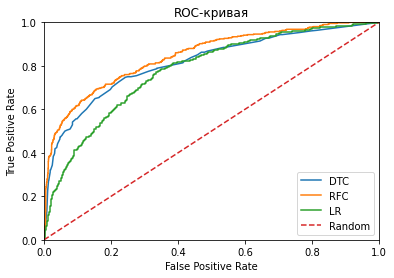

In [47]:
# Построим график с ROC-кривыми моделей 
# Строим кривую по модели "Дерево решений"
model = DecisionTreeClassifier(random_state=12345, max_depth= 8) 
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_DTC_valid = probabilities_valid[:, 1]
t_fpr, t_tpr, t_thresholds = roc_curve(target_valid, probabilities_DTC_valid)
plt.plot(t_fpr, t_tpr, label="DTC")

# Строим кривую по модели "Случайный лес"
model_rand = RandomForestClassifier(random_state=12345, n_estimators=14, max_depth= 10)
model_rand.fit(features_train, target_train)
probabilities_valid = model_rand.predict_proba(features_valid)
probabilities_RFC_valid = probabilities_valid[:, 1]
auc_roc_RFC = roc_auc_score(target_valid, probabilities_one_valid)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(target_valid, probabilities_RFC_valid)
plt.plot(rf_fpr, rf_tpr,label="RFC")

# Строим кривую по модели "Логистическая регрессия"
model_log = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100) 
model_log.fit(features_train, target_train)
probabilities_valid = model_log.predict_proba(features_valid)
probabilities_LR_valid = probabilities_valid[:, 1]
lr_fpr, lr_tpr, lr_thresholds = roc_curve(target_valid, probabilities_LR_valid)
plt.plot(lr_fpr, lr_tpr, label="LR")


# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], label="Random", linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(fontsize=10)
plt.show()

    Вывод: 
    Наилучшей моделью оказалась "Случайный лес", F1 на валидационной выборке = 0.602, AUC_ROC = 0.84.
    На графике наглядно видим, что "Случайный лес" более точен.

## Улучшение модели с учетом дисбаланса. Выбор лучшей модели.

Построим модели учитывая дисбаланс классов.

In [15]:
# Исследуем баланс классов на обучающей выборке
target_train.value_counts()

0    4778
1    1222
Name: exited, dtype: int64

In [48]:
# с помощью техники upsampling увеличим вес меньшего класса
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)



In [49]:
# Построим DecisionTree на сбалансированной обучающей выборке
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc_DTC = roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result:
        best_result = result
        best_depth = depth 
        auc_roc = auc_roc_DTC
 
print(
    'f1 на валидационной выборке:',best_result, 
    'Максимальная глубина:', best_depth, 
    'AUC_ROC:', auc_roc
)

f1 на валидационной выборке: 0.5847826086956522 Максимальная глубина: 5 AUC_ROC: 0.8225910496107992


Модель "Дерево решений" показала наилучший результат при глубине = 5. F1-мера повысилась по сравнению с моделью обученной на несбалансированной выборке. Была 0.57, стала 0,584. Значение AUC_ROC также увеличилось.

In [51]:
# Построим Random forest на сбалансированной обучающей выборке
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1, 20, 1):
    for depth in range (1, 15, 1):
        model_rand = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth= depth)
        model_rand.fit(features_upsampled, target_upsampled)
        predicted_valid = model_rand.predict(features_valid)
        result_valid = f1_score(target_valid, predicted_valid)
        probabilities_valid = model_rand.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc_RFC = roc_auc_score(target_valid, probabilities_one_valid)
        if result_valid > best_result:
            best_result = result_valid
            best_est = est
            best_depth = depth  
            auc_roc = auc_roc_RFC
            
            
print(
     "F1 на валидационной выборке:", best_result,
    "Количество деревьев:", best_est, "Максимальная глубина:", best_depth, 'AUC_ROC:', auc_roc
)

F1 на валидационной выборке: 0.6109839816933639 Количество деревьев: 17 Максимальная глубина: 11 AUC_ROC: 0.8347428010148783


Модель "Случайный лес" показала наилучшие результаты при количетве деревьев = 17 и глубине = 11.
F1- мера увеличилась с 0.602 и стала = 0.611, но понизилось значение AUC_ROC. Было 0,84, стало 0,834

In [52]:
# Построим Логистическую регрессию на сбалансированной обучающей выборке
model_log = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100) 
model_log.fit(features_upsampled, target_upsampled)
predicted_valid = model_log.predict(features_valid)
result_valid = f1_score(target_valid, predicted_valid)
   
print("F1 на валидационной выборке:", result_valid)
probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_LR = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC_ROC:',auc_roc_LR)

F1 на валидационной выборке: 0.5088028169014084
AUC_ROC: 0.7807711966696226


Значение F1-меры для модели Логистической регрессии повысилось на сбалансированной выборке и стало 0,51 против 0,34.

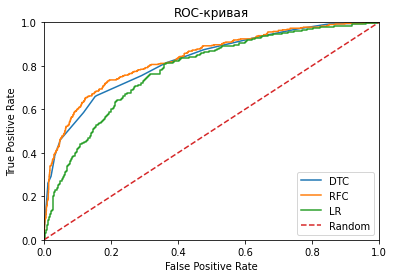

In [53]:
# Построим график с ROC-кривыми моделей 
# Строим кривую по модели "Дерево решений"
model = DecisionTreeClassifier(random_state=12345, max_depth= 5) 
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_DTC_valid = probabilities_valid[:, 1]
t_fpr, t_tpr, t_thresholds = roc_curve(target_valid, probabilities_DTC_valid)
plt.plot(t_fpr, t_tpr, label="DTC")

# Строим кривую по модели "Случайный лес"
model_rand = RandomForestClassifier(random_state=12345, n_estimators=17, max_depth= 11)
model_rand.fit(features_upsampled, target_upsampled)
probabilities_valid = model_rand.predict_proba(features_valid)
probabilities_RFC_valid = probabilities_valid[:, 1]
auc_roc_RFC = roc_auc_score(target_valid, probabilities_one_valid)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(target_valid, probabilities_RFC_valid)
plt.plot(rf_fpr, rf_tpr,label="RFC")

# Строим кривую по модели "Логистическая регрессия"
model_log = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100) 
model_log.fit(features_upsampled, target_upsampled)
probabilities_valid = model_log.predict_proba(features_valid)
probabilities_LR_valid = probabilities_valid[:, 1]
lr_fpr, lr_tpr, lr_thresholds = roc_curve(target_valid, probabilities_LR_valid)
plt.plot(lr_fpr, lr_tpr, label="LR")


# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], label="Random", linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(fontsize=10)
plt.show()

Вывод: 
После балансировки на обучающей выборке модели стали предсказывать лучше. Наилучшей моделью оказалась "Случайный лес", F1 на валидационной выборке = 0.61, AUC_ROC = 0.83.

### Рассмотрим модели, применив еще один вариант балансировки.

In [54]:
# DecisionTree
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 10, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth= depth, class_weight='balanced') 
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc_DTC = roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result:
        best_result = result
        best_depth = depth 
        auc_roc = auc_roc_DTC

print(
    'F1 на валидационной выборке:',best_result, 
    'Максимальная глубина:', best_depth, 
    'AUC_ROC:', auc_roc
)

F1 на валидационной выборке: 0.5847826086956522 Максимальная глубина: 5 AUC_ROC: 0.8225910496107992


Модель "Дерево решений" при использовании параметра class_weight='balanced' показала наилучший результат при глубине = 5. F1-мера осталась прежней по сравнению с моделью обученной на выборке сбалансированной с помощью апсемплинга. F1 на валидационной выборке: 0.584

In [57]:
# Random forest
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1, 30, 1):
    for depth in range (1, 10, 1):
        model_rand = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth= depth, class_weight='balanced')
        model_rand.fit(features_train, target_train)
        predicted_valid = model_rand.predict(features_valid)
        result_valid = f1_score(target_valid, predicted_valid)
        probabilities_valid = model_rand.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc_RFC = roc_auc_score(target_valid, probabilities_one_valid)
        if result_valid > best_result:
            best_result = result_valid
            best_est = est
            best_depth = depth  
            auc_roc = auc_roc_RFC
            
            

print(
    "F1 на валидационной выборке:", best_result,
    "Количество деревьев:", best_est, "Максимальная глубина:", best_depth, 'AUC_ROC:', auc_roc
)

F1 на валидационной выборке: 0.6139315230224321 Количество деревьев: 29 Максимальная глубина: 9 AUC_ROC: 0.8523746181889842


Модель "Случайный лес" показала наилучшие результаты при количетве деревьев = 29 и глубине = 9. F1- мера увеличилась с 0.611 и стала = 0.614, также повысилось значение AUC_ROC. Было 0,834, стало 0,852

In [58]:
# Логистическая регрессия
model_log = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100, class_weight='balanced') 
model_log.fit(features_train, target_train)
predicted_valid = model_log.predict(features_valid)
result_valid = f1_score(target_valid, predicted_valid)
   
print("F1 на валидационной выборке:", result_valid)
probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_LR = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC_ROC:',auc_roc_LR)

F1 на валидационной выборке: 0.5088967971530249
AUC_ROC: 0.7807588801852399


Значение F1-меры для модели Логистической регрессии не изменилось.

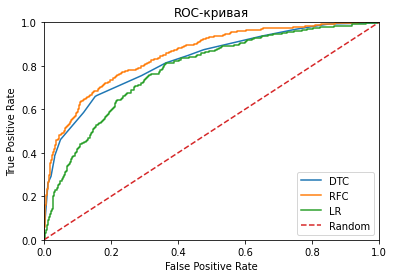

In [60]:
# Построим график с ROC-кривыми моделей 
# Строим кривую по модели "Дерево решений"
model = DecisionTreeClassifier(random_state=12345, max_depth= 5, class_weight='balanced') 
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_DTC_valid = probabilities_valid[:, 1]
t_fpr, t_tpr, t_thresholds = roc_curve(target_valid, probabilities_DTC_valid)
plt.plot(t_fpr, t_tpr, label="DTC")

# Строим кривую по модели "Случайный лес"
model_rand = RandomForestClassifier(random_state=12345, n_estimators=29, max_depth= 9, class_weight='balanced')
model_rand.fit(features_train, target_train)
probabilities_valid = model_rand.predict_proba(features_valid)
probabilities_RFC_valid = probabilities_valid[:, 1]
auc_roc_RFC = roc_auc_score(target_valid, probabilities_one_valid)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(target_valid, probabilities_RFC_valid)
plt.plot(rf_fpr, rf_tpr,label="RFC")

# Строим кривую по модели "Логистическая регрессия"
model_log = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100, class_weight='balanced') 
model_log.fit(features_train, target_train)
probabilities_valid = model_log.predict_proba(features_valid)
probabilities_LR_valid = probabilities_valid[:, 1]
lr_fpr, lr_tpr, lr_thresholds = roc_curve(target_valid, probabilities_LR_valid)
plt.plot(lr_fpr, lr_tpr, label="LR")


# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], label="Random", linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(fontsize=10)
plt.show()

## Финальное тестирование модели.

In [64]:
# Проведем проверку наилучшей модели на тестовой выборке
# Выборка сбалансирована апсемплингом
model_rand = RandomForestClassifier(random_state=12345, n_estimators=17, max_depth= 11)
model_rand.fit(features_upsampled, target_upsampled)
predicted_test = model_rand.predict(features_test)
print('F1_test:', f1_score(target_test, predicted_test))
probabilities_test = model_rand.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('auc_roc_RFC:', roc_auc_score(target_test, probabilities_one_test))

F1_test: 0.5969802555168408
auc_roc_RFC: 0.8370751336853032


In [65]:
# Проведем проверку наилучшей модели на тестовой выборке
# Выборка сбалансирована с помощью class_weight='balanced'
model_rand = RandomForestClassifier(random_state=12345, n_estimators=29, max_depth= 9, class_weight='balanced')
model_rand.fit(features_train, target_train)
predicted_test = model_rand.predict(features_test)
print('F1_test:', f1_score(target_test, predicted_test))
probabilities_test = model_rand.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('auc_roc_RFC:', roc_auc_score(target_test, probabilities_one_test))

F1_test: 0.5967365967365966
auc_roc_RFC: 0.8432901314257246


Вывод: Мы видим, что оба варианта балансировки показывают примерно равные значения F1-меры на тестовых выборках, однако auc_roc говорит нам о том, что качественнее модель получается при исплльзовании параметра class_weight='balanced'.